# Идентификация интернет-пользователей

## 1. Цели и задачи проекта, описание исходных и обработанных данных и признаков.

В обучающей выборке **train_sessions_400users.csv** признаки **site_i** – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем **site_dic.pkl**).
Признаки **time_j** – время посещения сайтов **site_j**.

Целевой признак **user_id** – ID, пользователя, которому принадлежит сессия из 10 посещений веб-сайтов.

Задача – сделать прогнозы для сессий в тестовой выборке (**test_sessions_400users.csv**), определить, каким пользователям они принадлежат.

Цель: по последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, идентифицировать этого человека. 

In [79]:
import os
import pandas as pd
import numpy as np
import scipy.sparse as sps
from time import time
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import preprocessing
from collections import Counter

In [80]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [81]:
import scipy.sparse as sps
from scipy.sparse import csr_matrix
from tqdm.auto import tqdm
from time import time

## 2. Первичный анализ признаков

In [82]:
PATH_TO_DATA = 'capstone_user_identification'

In [83]:
train_df_400 = pd.read_csv(os.path.join(PATH_TO_DATA,'train_sessions_400users.csv'), 
                           index_col='session_id')

In [84]:
test_df_400 = pd.read_csv(os.path.join(PATH_TO_DATA,'test_sessions_400users.csv'), 
                           index_col='session_id')

In [85]:
train_df_400.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
1,23713,2014-03-24 15:22:40,23720.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:54,23720.0,2014-03-24 15:22:54,23713.0,2014-03-24 15:22:55,23713.0,2014-03-24 15:23:01,23713.0,2014-03-24 15:23:03,23713.0,2014-03-24 15:23:04,23713.0,2014-03-24 15:23:05,653
2,8726,2014-04-17 14:25:58,8725.0,2014-04-17 14:25:59,665.0,2014-04-17 14:25:59,8727.0,2014-04-17 14:25:59,45.0,2014-04-17 14:25:59,8725.0,2014-04-17 14:26:01,45.0,2014-04-17 14:26:01,5320.0,2014-04-17 14:26:18,5320.0,2014-04-17 14:26:47,5320.0,2014-04-17 14:26:48,198
3,303,2014-03-21 10:12:24,19.0,2014-03-21 10:12:36,303.0,2014-03-21 10:12:54,303.0,2014-03-21 10:13:01,303.0,2014-03-21 10:13:24,303.0,2014-03-21 10:13:36,303.0,2014-03-21 10:13:54,309.0,2014-03-21 10:14:01,303.0,2014-03-21 10:14:06,303.0,2014-03-21 10:14:24,34
4,1359,2013-12-13 09:52:28,925.0,2013-12-13 09:54:34,1240.0,2013-12-13 09:54:34,1360.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:54:34,1359.0,2013-12-13 09:54:34,1346.0,2013-12-13 09:54:34,1345.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:58:19,1345.0,2013-12-13 09:58:19,601
5,11,2013-11-26 12:35:29,85.0,2013-11-26 12:35:31,52.0,2013-11-26 12:35:31,85.0,2013-11-26 12:35:32,11.0,2013-11-26 12:35:32,52.0,2013-11-26 12:35:32,11.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:03,10.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:04,273


In [86]:
train_df_400.shape, test_df_400.shape, train_df_400['user_id'].nunique()

((182793, 21), (46473, 20), 400)

**<span style="color:green">Видим, что в обучающей выборке 182793 сессий, в тестовой – 46473, и сессии действительно принадлежат 400 различным пользователям.</span>**

In [87]:
y = train_df_400.user_id
class_encoder = preprocessing.LabelEncoder()
y_for_vw = class_encoder.fit_transform(y)+1

In [88]:
sites = ['site' + str(i) for i in range(1, 11)]

In [89]:
path_pkl = os.path.join(PATH_TO_DATA, 'site_dic.pkl')
unpickled_df = pd.read_pickle(path_pkl)

In [90]:
#проверяем количество NaN 

train_df_400[sites].isnull().sum().sum()

66164

In [91]:
# заменяем NaN на 0 и преобразуем в матрицу

example_series = train_df_400[sites].fillna(0).astype(int).values

In [92]:
count_sites = pd.Series([item for sublist in example_series for item in sublist]).value_counts()

**<span style="color:green">Вывел наиболее популярные 10 сайтов</span>**

In [93]:
index_site = list(count_sites.index)
index_site.remove(0)
for ind in index_site[:10]:
    print([k for k,v in unpickled_df.items() if v == ind])

['www.google.fr']
['annotathon.org']
['www.google.com']
['www.facebook.com']
['apis.google.com']
['blast.ncbi.nlm.nih.gov']
['www.ncbi.nlm.nih.gov']
['clients1.google.com']
['mail.google.com']
['s.youtube.com']


In [94]:
len(index_site)

32343

**<span style="color:green">Всего уникальных сайтов в тренировочном сете 32343. Важно отметить, что показатель ниже, чем в словаре. Возможно оставшиеся сайты в проверочном сете.</span>**

In [95]:
#проверяем количество NaN в test

test_df_400[sites].isnull().sum().sum()

15694

In [96]:
example_series_test = test_df_400[sites].fillna(0).astype(int).values
count_sites_test = pd.Series([item for sublist in example_series_test for item in sublist]).value_counts()

In [97]:
index_site_test = list(count_sites_test.index)
index_site_test.remove(0)
for ind in index_site_test[:10]:
    print([k for k,v in unpickled_df.items() if v == ind])

['annotathon.org']
['www.google.fr']
['www.ncbi.nlm.nih.gov']
['www.facebook.com']
['www.google.com']
['s.youtube.com']
['apis.google.com']
['www.phylogeny.fr']
['www.bing.com']
['clients1.google.com']


In [98]:
for i in index_site[:10]:
    if i in index_site_test[:10]:
        print("BINGO")
    else:
        print("NONE")

BINGO
BINGO
BINGO
BINGO
BINGO
NONE
BINGO
BINGO
NONE
BINGO


**<span style="color:green">Вывел наиболее популярные 10 сайтов в тесте. Видно совпадение 8 сайтов в тренировочном с тестовым, правда не по порядку</span>**

**<span style="color:green">ID наиболее активных пользователей</span>**

In [99]:
top_10 = train_df_400.user_id.value_counts()[:10]
top_10.index

Int64Index([149, 405, 984, 361, 884, 104, 251, 989, 48, 68], dtype='int64')

In [100]:
train_df_400_sites = train_df_400[sites]
train_df_400_sites.shape

(182793, 10)

In [101]:
num_unique_sites = [np.unique(train_df_400_sites.values[i, :-1]).shape[0] 
                    for i in range(train_df_400_sites.shape[0])]

**<span style="color:green">Количество уникальных сайтов в каждой сессии</span>**

In [102]:
pd.Series(num_unique_sites).value_counts()

7    31115
6    29734
8    25215
5    24965
4    17836
9    16677
3    14756
2    13054
1     9441
dtype: int64

In [103]:
import pylab 
import scipy.stats as stats

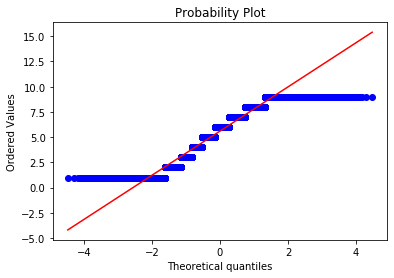

In [104]:
stats.probplot(num_unique_sites, dist="norm", plot=pylab)
pylab.show()

In [105]:
stat, p = stats.shapiro(num_unique_sites)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.943, p=0.000
Sample does not look Gaussian (reject H0)


**<span style="color:green">Верно, распределение не нормально – хвосты тяжелые.</span>**

**Найду p-value, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов.**

In [106]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [107]:
has_two_similar.sum()

182793

In [108]:
stats.binom_test(has_two_similar.sum(), has_two_similar.shape[0], 0.95, alternative='greater')

0.0

**<span style="color:green">Вероятность незначительная<span>**

In [109]:
from statsmodels.stats.proportion import proportion_confint

In [110]:
wilson_interval = proportion_confint(has_two_similar.sum(), has_two_similar.shape[0], method='wilson')
wilson_interval

(0.9999789850919195, 1.0000000000000002)

**95%-доверительный интервал Уилсона для величины из прошлого вопроса**

In [111]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [112]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [113]:
import matplotlib.pyplot as plt

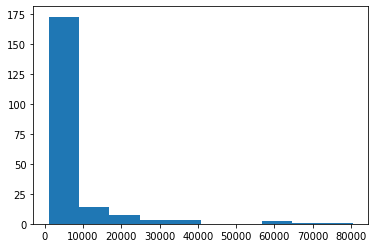

In [114]:
sorted_site_1000 = {}

for key, value in count_sites.items():
    if value >= 1000:
        sorted_site_1000[key] = value
    
plt.hist(list(sorted_site_1000.values()))
plt.show()

**Распределение сайтов с частотой более 1000**

In [115]:
sorted_site_5 = {}

for key, value in count_sites.items():
    if value >= 5:
        sorted_site_5[key] = value

In [116]:
site_freq = list(sorted_site_5.values())
len(site_freq)

11756

In [117]:
site_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(site_freq), len(site_freq))))

In [118]:
#количество посещений сайтов на которые заходили меньше, чем пять раз

sorted_site_4 = {}

for key, value in count_sites.items():
    if value < 5:
        if value in sorted_site_4.keys():
            sorted_site_4[value] = sorted_site_4[value] + 1
        else:
            sorted_site_4[value] = 1
        
print(sorted_site_4)

{4: 1828, 3: 2681, 2: 4304, 1: 11775}


In [119]:
print ("95% доверительный интервал для средней частоты появления сайта в выборке которые были посещены минимум 5 раз :")
print(stat_intervals(site_mean_scores, 0.05))

95% доверительный интервал для средней частоты появления сайта в выборке которые были посещены минимум 5 раз :
[124.22213125 184.50040405]


**<span style="color:green">То есть сайты, которые посещают более пяти раз как правило посещают с частотой от 124 до 184 раз. Наиболее часто на сайт заходят один раз и больше не посещают. Дальше идет общая тенденция на понижение</span>**

In [120]:
# создание разряженной матрицы

def create_sparse_matrix(dataframe):
    tmp_arr = np.array(dataframe)
    row = 0
    rows = []
    cols = []
    data = []

    for arr in tmp_arr:
        #print(arr)
        for i, val in enumerate(arr):
            if val != 0:                
                data.append(val)
                cols.append(i)
                rows.append(row)
        row = row + 1
        
    return(sps.coo_matrix((data, (rows, cols))))

In [121]:
train_sparse = csr_matrix(create_sparse_matrix(test_df_400[sites].fillna(0)))

## 3 Первичный визуальный анализ признаков

In [123]:
train_df_400_full = train_df_400.copy()
#train_df_400_full = train_df_400_full.fillna(0)

In [124]:
train_df_400_full.time1 = pd.to_datetime(train_df_400_full.time1)
train_df_400_full.time2 = pd.to_datetime(train_df_400_full.time2)
train_df_400_full.time3 = pd.to_datetime(train_df_400_full.time3)
train_df_400_full.time4 = pd.to_datetime(train_df_400_full.time4)
train_df_400_full.time5 = pd.to_datetime(train_df_400_full.time5)
train_df_400_full.time6 = pd.to_datetime(train_df_400_full.time6)
train_df_400_full.time7 = pd.to_datetime(train_df_400_full.time7)
train_df_400_full.time8 = pd.to_datetime(train_df_400_full.time8)
train_df_400_full.time9 = pd.to_datetime(train_df_400_full.time9)
train_df_400_full.time10 = pd.to_datetime(train_df_400_full.time10)

In [125]:
train_df_400_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182793 entries, 1 to 182793
Data columns (total 21 columns):
site1      182793 non-null int64
time1      182793 non-null datetime64[ns]
site2      181175 non-null float64
time2      181175 non-null datetime64[ns]
site3      179441 non-null float64
time3      179441 non-null datetime64[ns]
site4      178054 non-null float64
time4      178054 non-null datetime64[ns]
site5      176653 non-null float64
time5      176653 non-null datetime64[ns]
site6      175268 non-null float64
time6      175268 non-null datetime64[ns]
site7      173960 non-null float64
time7      173960 non-null datetime64[ns]
site8      172738 non-null float64
time8      172738 non-null datetime64[ns]
site9      171437 non-null float64
time9      171437 non-null datetime64[ns]
site10     170247 non-null float64
time10     170247 non-null datetime64[ns]
user_id    182793 non-null int64
dtypes: datetime64[ns](10), float64(9), int64(2)
memory usage: 30.7 MB


In [126]:
train_df_400_full['time_diff_1'] = (train_df_400_full.time2 - train_df_400_full.time1)/np.timedelta64(1,'s')
train_df_400_full['time_diff_2'] = (train_df_400_full.time3 - train_df_400_full.time2)/np.timedelta64(1,'s')
train_df_400_full['time_diff_3'] = (train_df_400_full.time4 - train_df_400_full.time3)/np.timedelta64(1,'s')
train_df_400_full['time_diff_4'] = (train_df_400_full.time5 - train_df_400_full.time4)/np.timedelta64(1,'s')
train_df_400_full['time_diff_5'] = (train_df_400_full.time6 - train_df_400_full.time5)/np.timedelta64(1,'s')
train_df_400_full['time_diff_6'] = (train_df_400_full.time7 - train_df_400_full.time6)/np.timedelta64(1,'s')
train_df_400_full['time_diff_7'] = (train_df_400_full.time8 - train_df_400_full.time7)/np.timedelta64(1,'s')
train_df_400_full['time_diff_8'] = (train_df_400_full.time9 - train_df_400_full.time8)/np.timedelta64(1,'s')
train_df_400_full['time_diff_9'] = (train_df_400_full.time10 - train_df_400_full.time9)/np.timedelta64(1,'s')

train_df_400_full['session_timespan'] = train_df_400_full['time_diff_1'] + train_df_400_full['time_diff_2'] + \
train_df_400_full['time_diff_3'] + train_df_400_full['time_diff_4'] + train_df_400_full['time_diff_5'] + \
train_df_400_full['time_diff_6'] + train_df_400_full['time_diff_7'] + train_df_400_full['time_diff_8'] + \
train_df_400_full['time_diff_9'] 



In [127]:
train_df_400_full['unique_sites'] = train_df_400_full[sites].apply(pd.Series.nunique, axis=1)

In [128]:
train_df_400_full['start_hour'] = train_df_400_full.time1.dt.hour

In [129]:
train_df_400_full['day_of_week'] = train_df_400_full.time1.dt.weekday

In [130]:
times = ['time' + str(i) for i in range(1, 11)]

In [133]:
train_df_400_full_site = train_df_400_full.drop(['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10'], axis=1)

In [134]:
train_df_400_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182793 entries, 1 to 182793
Data columns (total 34 columns):
site1               182793 non-null int64
time1               182793 non-null datetime64[ns]
site2               181175 non-null float64
time2               181175 non-null datetime64[ns]
site3               179441 non-null float64
time3               179441 non-null datetime64[ns]
site4               178054 non-null float64
time4               178054 non-null datetime64[ns]
site5               176653 non-null float64
time5               176653 non-null datetime64[ns]
site6               175268 non-null float64
time6               175268 non-null datetime64[ns]
site7               173960 non-null float64
time7               173960 non-null datetime64[ns]
site8               172738 non-null float64
time8               172738 non-null datetime64[ns]
site9               171437 non-null float64
time9               171437 non-null datetime64[ns]
site10              170247 non-null 

In [135]:
train_df_400_full.head(20)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,...,time_diff_2,time_diff_3,time_diff_4,time_diff_5,time_diff_6,time_diff_7,time_diff_8,time_diff_9,session_timespan,unique_sites,start_hour,day_of_week
session_id,,,,,,,,,,,,,,,,,,,,,,,,,
1,23713,2014-03-24 15:22:40,23720.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:54,23720.0,2014-03-24 15:22:54,23713.0,2014-03-24 15:22:55,...,0.0,6.0,0.0,1.0,6.0,2.0,1.0,1.0,25.0,2,15,0
2,8726,2014-04-17 14:25:58,8725.0,2014-04-17 14:25:59,665.0,2014-04-17 14:25:59,8727.0,2014-04-17 14:25:59,45.0,2014-04-17 14:25:59,8725.0,2014-04-17 14:26:01,...,0.0,0.0,0.0,2.0,0.0,17.0,29.0,1.0,50.0,6,14,3
3,303,2014-03-21 10:12:24,19.0,2014-03-21 10:12:36,303.0,2014-03-21 10:12:54,303.0,2014-03-21 10:13:01,303.0,2014-03-21 10:13:24,303.0,2014-03-21 10:13:36,...,18.0,7.0,23.0,12.0,18.0,7.0,5.0,18.0,120.0,3,10,4
4,1359,2013-12-13 09:52:28,925.0,2013-12-13 09:54:34,1240.0,2013-12-13 09:54:34,1360.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:54:34,1359.0,2013-12-13 09:54:34,...,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,351.0,7,9,4
5,11,2013-11-26 12:35:29,85.0,2013-11-26 12:35:31,52.0,2013-11-26 12:35:31,85.0,2013-11-26 12:35:32,11.0,2013-11-26 12:35:32,52.0,2013-11-26 12:35:32,...,0.0,1.0,0.0,0.0,91.0,0.0,0.0,1.0,95.0,4,12,1
6,83,2014-01-24 14:06:48,1344.0,2014-01-24 14:06:49,1240.0,2014-01-24 14:06:49,1359.0,2014-01-24 14:06:57,1345.0,2014-01-24 14:06:58,85.0,2014-01-24 14:07:14,...,0.0,8.0,1.0,16.0,10.0,12.0,0.0,0.0,48.0,8,14,4
7,13585,2013-11-20 14:45:16,13585.0,2013-11-20 14:45:17,13585.0,2013-11-20 14:45:18,13585.0,2013-11-20 14:45:19,13585.0,2013-11-20 14:45:21,13585.0,2013-11-20 14:45:22,...,1.0,1.0,2.0,1.0,2.0,4.0,0.0,2.0,14.0,2,14,2
8,29312,2013-02-12 08:42:54,29311.0,2013-02-12 08:42:54,29312.0,2013-02-12 08:42:55,29312.0,2013-02-12 08:42:56,NaN,NaT,NaN,NaT,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,8,1
9,21,2013-11-16 13:35:17,62.0,2013-11-16 13:35:17,18.0,2013-11-16 13:35:17,1387.0,2013-11-16 13:35:17,7.0,2013-11-16 13:35:17,72.0,2013-11-16 13:35:17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,13,5


In [136]:
import statistics

In [137]:
median = statistics.median(train_df_400_full.session_timespan.values)
print('Медианная продолжительность сессии для сессий пользователей составляет ', median)

Медианная продолжительность сессии для сессий пользователей составляет  51.0


In [138]:
median = statistics.median(train_df_400_full.day_of_week.values)
print('Медианная день недели для сессий пользователей составляет ', median)

Медианная день недели для сессий пользователей составляет  2


In [139]:
median = statistics.median(train_df_400_full.start_hour.values)
print('Медианный час для начала сессии для пользователей составляет ', median)

Медианный час для начала сессии для пользователей составляет  12


In [140]:
median = statistics.median(train_df_400_full['unique_sites'].values)
print('Медианное значение числа уникальных сайтов для пользователей составляет ', median)

Медианное значение числа уникальных сайтов для пользователей составляет  6


In [141]:
train_df_400_full.session_timespan = train_df_400_full.session_timespan.clip(lower=0)

In [142]:
x = train_df_400_full.session_timespan

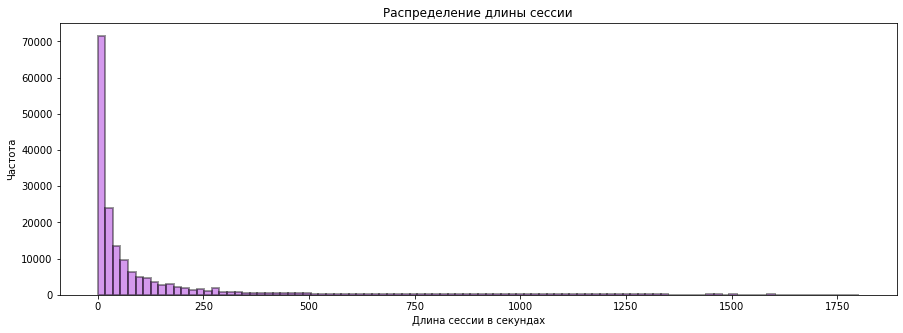

In [143]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.distplot(x, bins=100, kde=False, color='darkviolet', hist_kws=dict(edgecolor="k", linewidth=2))
plt.title("Распределение длины сессии")
plt.xlabel("Длина сессии в секундах")
plt.ylabel("Частота")
plt.show()

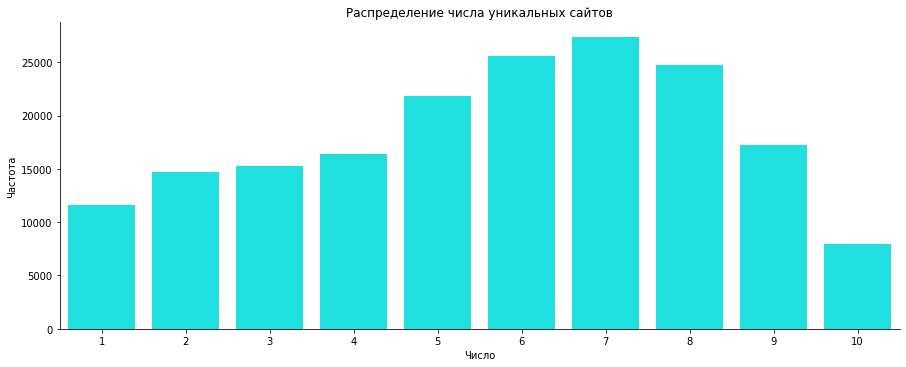

In [144]:
ax =sns.catplot(x="unique_sites", kind="count", color='aqua', data=train_df_400_full, height=5, aspect=2.5)
plt.title("Распределение числа уникальных сайтов", fontsize=12)
plt.xlabel("Число", fontsize=10)
plt.ylabel("Частота", fontsize=10)
plt.show()

In [145]:
train_df_400_full_top = train_df_400_full[(train_df_400_full.user_id == 149) | (train_df_400_full.user_id == 405) |
                  (train_df_400_full.user_id == 984) | (train_df_400_full.user_id == 361) |
                 (train_df_400_full.user_id == 884) | (train_df_400_full.user_id == 104) |
                 (train_df_400_full.user_id == 251) | (train_df_400_full.user_id == 989) |
                 (train_df_400_full.user_id == 48) | (train_df_400_full.user_id == 68)]

In [146]:
color_dic = {'149': 'pink', '405': 'darkviolet', '984':'blueviolet', 
             '361': 'hotpink', '884': 'orchid', 
             '104': 'firebrick', '251': 'gold', '989': 'forestgreen', 
             '48': 'slategrey', '68':'brown'}

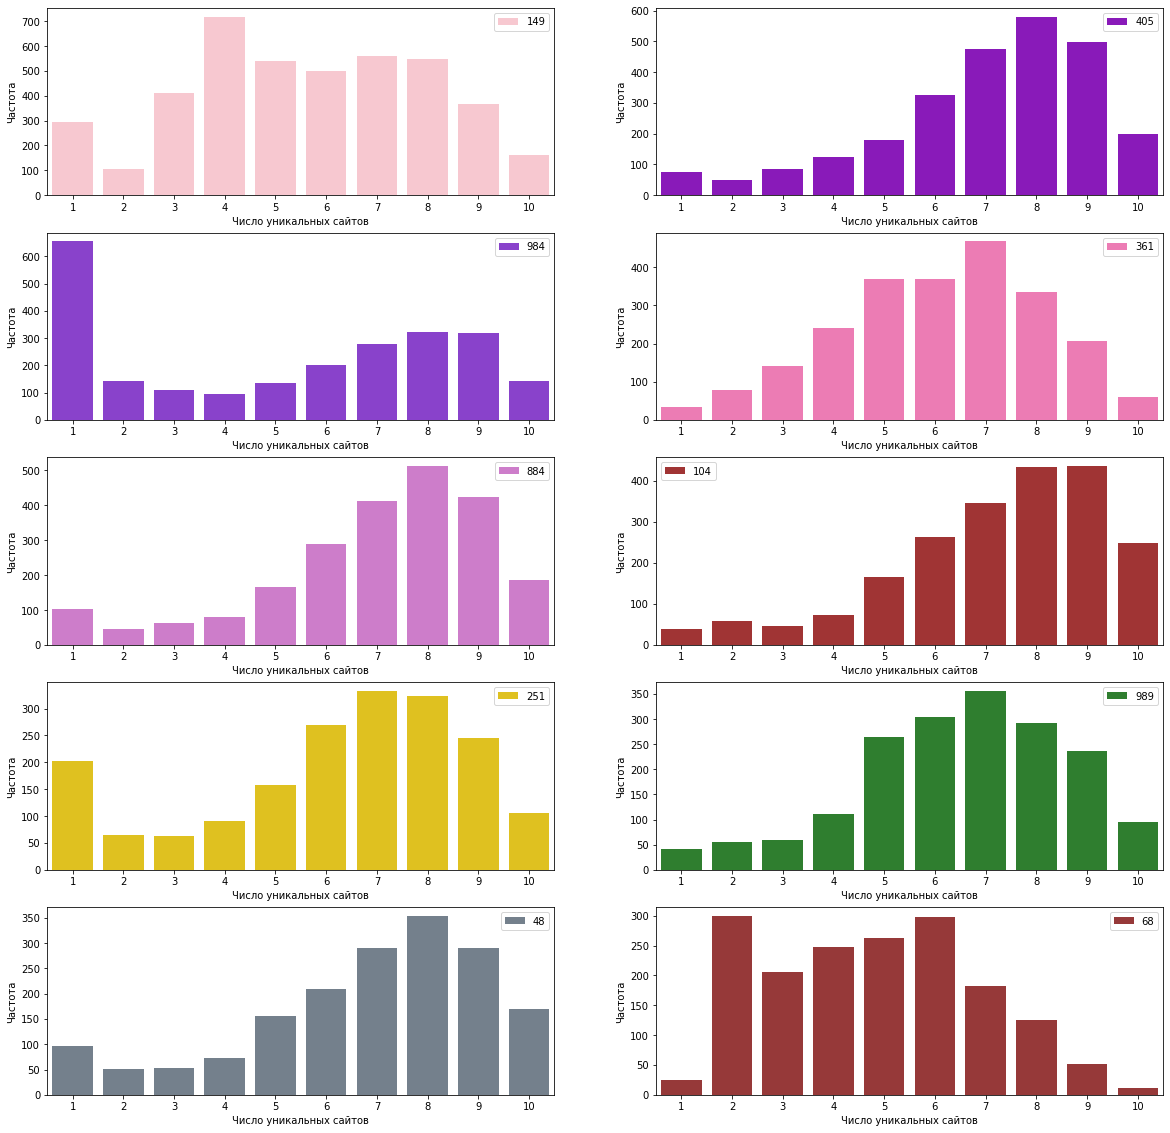

In [147]:
list_user = list(color_dic.keys())

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
set_user = set(train_df_400_full_top.user_id)

user = 0
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_df_400_full_top[train_df_400_full_top.user_id == int(list_user[user])]["unique_sites"],
                      color=color_dic[list_user[user]], ax=axes[idx, i])
        axes[idx, i].set_xlabel('Число уникальных сайтов')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend([list_user[user]])
        user = user + 1

**<span style="color:green">Вывел графики для топов пользователей. Как правило у топов число уникальных сайтов около 8 - 7</span>**

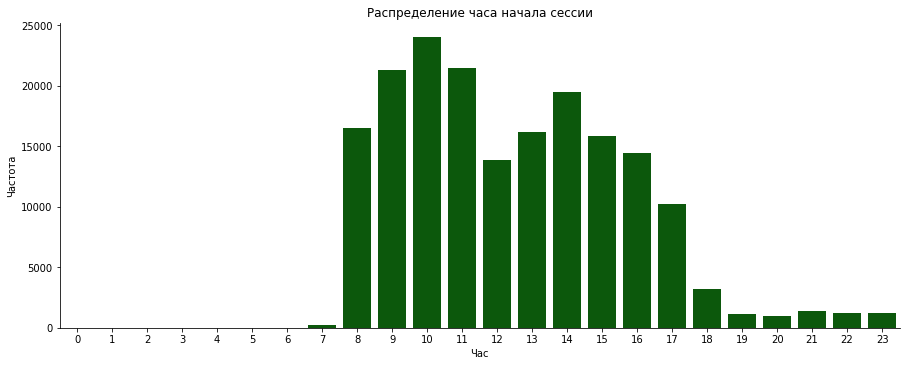

In [148]:
ax =sns.catplot(x="start_hour", kind="count", color='darkgreen', data=train_df_400_full,
                order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                height=5, aspect=2.5)
plt.title("Распределение часа начала сессии", fontsize=12)
plt.xlabel("Час", fontsize=10)
plt.ylabel("Частота", fontsize=10)
plt.show()

**<span style="color:green">Из графика становиться понятно, что до 7 утра никто не выходит в интрнет. Максимум наблюдается на 10 утра и 14 часов дня. После 17 частота падает значительно и держиться практически на одном уровне с незначительной просадкой в 19. </span>**

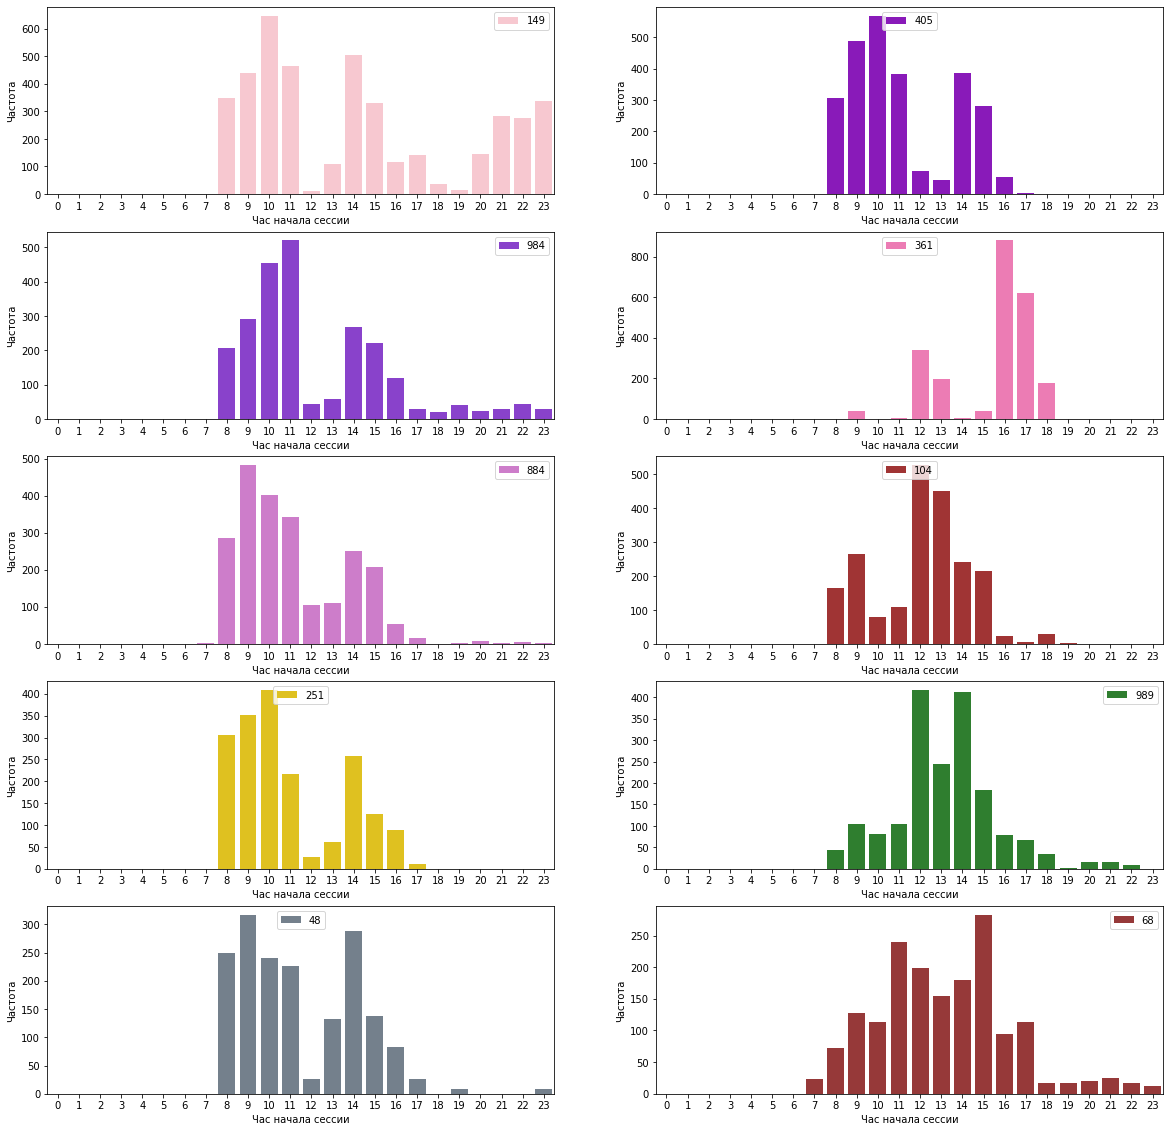

In [149]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
#set_user = set(train_data_10users.target)

user = 0
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_df_400_full_top[train_df_400_full_top.user_id == int(list_user[user])]["start_hour"],
                      color=color_dic[list_user[user]], 
                      order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                      ax=axes[idx, i])
        axes[idx, i].set_xlabel('Час начала сессии')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend([list_user[user]])
        user = user + 1

**<span style="color:green">У 6 пользователей из топа картинка распределения совпадает с общей картинкой, а у четырех более специфичное распределение. </span>**

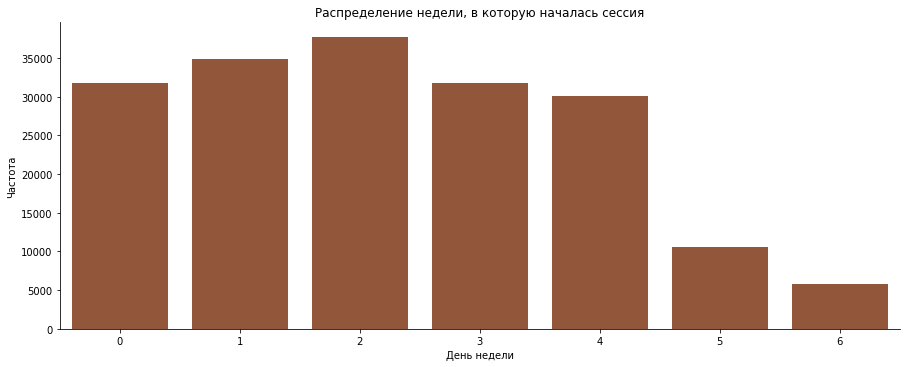

In [150]:
ax =sns.catplot(x="day_of_week", kind="count", color='sienna', data=train_df_400_full, height=5, aspect=2.5)
plt.title("Распределение недели, в которую началась сессия", fontsize=12)
plt.xlabel("День недели", fontsize=10)
plt.ylabel("Частота", fontsize=10)
plt.show()

**<span style="color:green">У пользователей наблюдается тяга к среде. На выходных частота падает значительно. </span>**

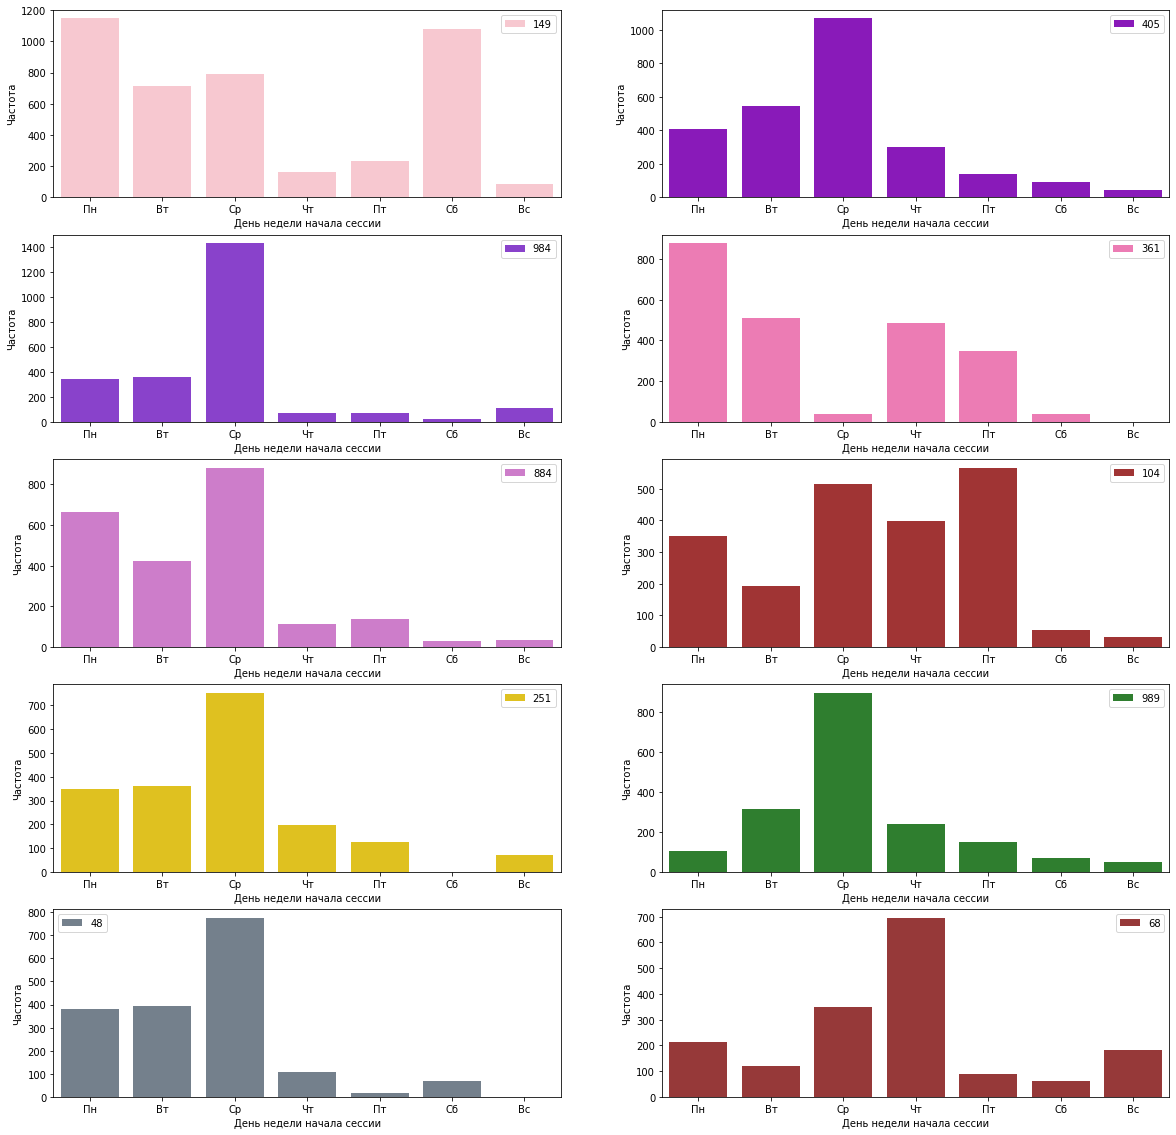

In [151]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

user = 0
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_df_400_full_top[train_df_400_full_top.user_id == int(list_user[user])]["day_of_week"],
                      color=color_dic[list_user[user]], order = [0, 1, 2, 3, 4, 5, 6], ax=axes[idx, i])
        axes[idx, i].set_xlabel('День недели начала сессии')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend([list_user[user]])
        axes[idx, i].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб',  'Вс'])
        user = user+1

**<span style="color:green">У 6 пользователей из топа наблюдается так же максимум в среду. Один проявляет интерес в субботу, что не спецефично для общей картины. </span>**

In [152]:
top_10_sites={}

index_site_test = list(count_sites_test.index)
index_site_test.remove(0)
for ind in index_site_test[:10]:
    site = [k for k,v in unpickled_df.items() if v == ind][0]
    top_10_sites[site] = count_sites_test.get(ind)

In [153]:
top_10_sites

{'annotathon.org': 22924,
 'www.google.fr': 18413,
 'www.ncbi.nlm.nih.gov': 16279,
 'www.facebook.com': 13388,
 'www.google.com': 13356,
 's.youtube.com': 11306,
 'apis.google.com': 8948,
 'www.phylogeny.fr': 7915,
 'www.bing.com': 6869,
 'clients1.google.com': 6236}

In [154]:
top_10_sites.values()
[v for k,v in top_10_sites.items()]

[22924, 18413, 16279, 13388, 13356, 11306, 8948, 7915, 6869, 6236]

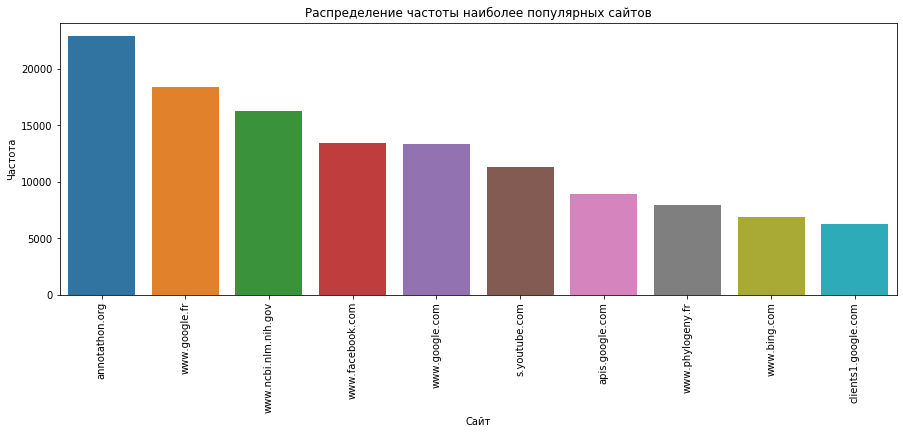

In [155]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(x=[k for k,v in top_10_sites.items()], y=[v for k,v in top_10_sites.items()])
plt.xticks(rotation = 90)
plt.title("Распределение частоты наиболее популярных сайтов", fontsize=12)
plt.xlabel("Сайт", fontsize=10)
plt.ylabel("Частота", fontsize=10)
plt.show()

In [156]:
train_df_400_full['weekday'] = train_df_400_full['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

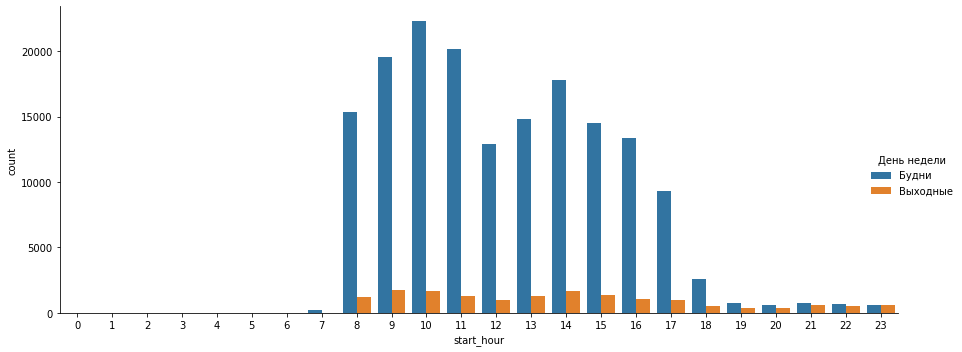

In [157]:
ax =sns.catplot(x="start_hour", kind="count", hue="weekday", data=train_df_400_full,
                order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                height=5, aspect=2.5)

# title
new_title = 'День недели'
ax._legend.set_title(new_title)
# replace labels
new_labels = ['Будни', 'Выходные']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l)

In [158]:
top_10_sites

{'annotathon.org': 22924,
 'www.google.fr': 18413,
 'www.ncbi.nlm.nih.gov': 16279,
 'www.facebook.com': 13388,
 'www.google.com': 13356,
 's.youtube.com': 11306,
 'apis.google.com': 8948,
 'www.phylogeny.fr': 7915,
 'www.bing.com': 6869,
 'clients1.google.com': 6236}

In [159]:
train_df_400_full_top['weekday'] = train_df_400_full_top['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

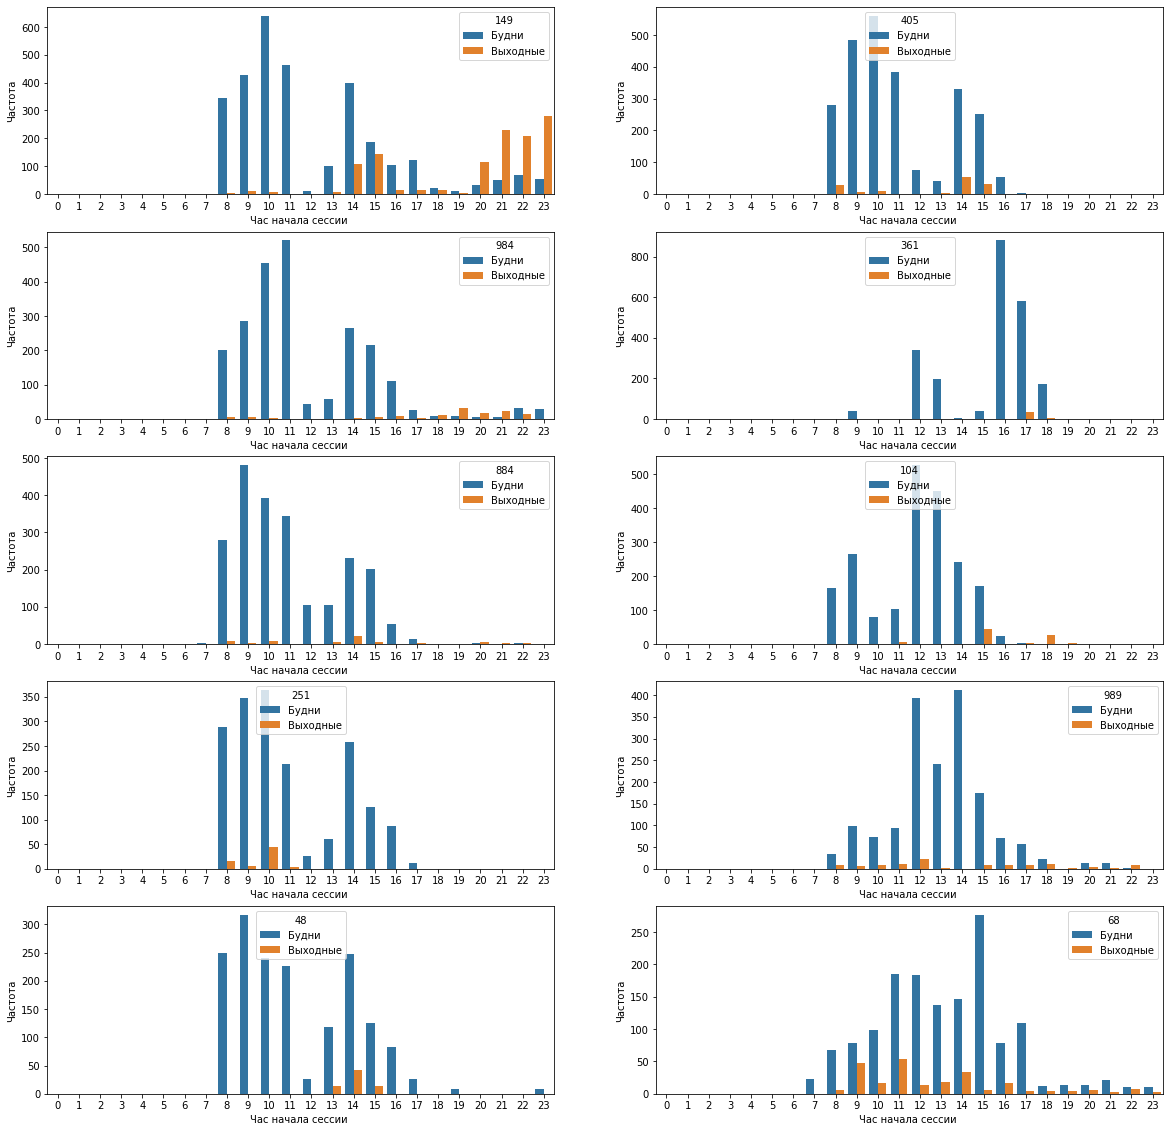

In [160]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

user = 0
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_df_400_full_top[train_df_400_full_top.user_id == int(list_user[user])]["start_hour"], hue = 'weekday',
                      data = train_df_400_full_top,
                      order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                      ax=axes[idx, i])
        axes[idx, i].set_xlabel('Час начала сессии ')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend(['Будни', 'Выходные'], title = list_user[user])
        user = user + 1

**<span style="color:green"> Расссмотрение распределения по времени в зависимости от того, выходные это дни или будние дни принес дополнительные характеристики по пользователям. У всех пользователей значительно падает частота выхода в интрнет в выходные дни. Пользователь 149 испытывает тягу выходить в интернет в вечернее время. </span>**

## 4. Сравнение алгоритмов классификации.

In [161]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [170]:
def arrays_to_vw(X, y=None, train=True, out_file='tmp.vw'):
    X = np.nan_to_num(X)
    X = X.astype(int)
    
    with open(out_file, 'w') as f:
        print(X.shape)
        for i in range(X.shape[0]):
            string =  ' '.join([str(x) for x in X[i] if x != np.nan])
            if y is None:
                #print("NONE")
                f.write(str(1) + " | " + string + "\n")
            else:
                f.write(str(y[i]) + " | " + string + "\n")

In [171]:
test_df_400_full = test_df_400.copy()
#test_df_400_full = test_df_400_full.fillna(0)

In [172]:
test_df_400_full.time1 = pd.to_datetime(test_df_400_full.time1)
test_df_400_full.time2 = pd.to_datetime(test_df_400_full.time2)
test_df_400_full.time3 = pd.to_datetime(test_df_400_full.time3)
test_df_400_full.time4 = pd.to_datetime(test_df_400_full.time4)
test_df_400_full.time5 = pd.to_datetime(test_df_400_full.time5)
test_df_400_full.time6 = pd.to_datetime(test_df_400_full.time6)
test_df_400_full.time7 = pd.to_datetime(test_df_400_full.time7)
test_df_400_full.time8 = pd.to_datetime(test_df_400_full.time8)
test_df_400_full.time9 = pd.to_datetime(test_df_400_full.time9)
test_df_400_full.time10 = pd.to_datetime(test_df_400_full.time10)

In [173]:
test_df_400_full['time_diff_1'] = (test_df_400_full.time2 - test_df_400_full.time1)/np.timedelta64(1,'s')
test_df_400_full['time_diff_2'] = (test_df_400_full.time3 - test_df_400_full.time2)/np.timedelta64(1,'s')
test_df_400_full['time_diff_3'] = (test_df_400_full.time4 - test_df_400_full.time3)/np.timedelta64(1,'s')
test_df_400_full['time_diff_4'] = (test_df_400_full.time5 - test_df_400_full.time4)/np.timedelta64(1,'s')
test_df_400_full['time_diff_5'] = (test_df_400_full.time6 - test_df_400_full.time5)/np.timedelta64(1,'s')
test_df_400_full['time_diff_6'] = (test_df_400_full.time7 - test_df_400_full.time6)/np.timedelta64(1,'s')
test_df_400_full['time_diff_7'] = (test_df_400_full.time8 - test_df_400_full.time7)/np.timedelta64(1,'s')
test_df_400_full['time_diff_8'] = (test_df_400_full.time9 - test_df_400_full.time8)/np.timedelta64(1,'s')
test_df_400_full['time_diff_9'] = (test_df_400_full.time10 - test_df_400_full.time9)/np.timedelta64(1,'s')

test_df_400_full['session_timespan'] = test_df_400_full['time_diff_1'] + test_df_400_full['time_diff_2'] + \
test_df_400_full['time_diff_3'] + test_df_400_full['time_diff_4'] + test_df_400_full['time_diff_5'] + \
test_df_400_full['time_diff_6'] + test_df_400_full['time_diff_7'] + test_df_400_full['time_diff_8'] + \
test_df_400_full['time_diff_9'] 

In [174]:
test_df_400_full['unique_sites'] = test_df_400_full[sites].apply(pd.Series.nunique, axis=1)

In [175]:
test_df_400_full['start_hour'] = test_df_400_full.time1.dt.hour

In [176]:
test_df_400_full['day_of_week'] = test_df_400_full.time1.dt.weekday

In [177]:
test_df_400_full_site = test_df_400_full.drop(['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10'], axis=1)

In [178]:
arrays_to_vw(train_df_400_full_site.values, y_for_vw, True, 'kaggle_data_final/train_part.vw')
arrays_to_vw(test_df_400_full_site.values, None, False, 'kaggle_data_final/test.vw')

(182793, 24)
(46473, 23)


In [179]:
!vw --oaa 400 --passes 3 -c -k kaggle_data_final/train_part.vw -b 26 -f  kaggle_data_final_result/model.vw 

final_regressor = kaggle_data_final_result/model.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data_final/train_part.vw.cache
Reading datafile = kaggle_data_final/train_part.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      262        1       25
1.000000 1.000000            2            2.0       82      262       25
1.000000 1.000000            4            4.0      241       82       25
1.000000 1.000000            8            8.0      352      106       25
1.000000 1.000000           16           16.0      135       16       25
1.000000 1.000000           32           32.0       71      112       25
0.984375 0.968750           64           64.0      358      162       25
0.992188 1.000000          128          128.0      348      345       2

In [180]:
!vw -t -i kaggle_data_final_result/model.vw kaggle_data_final/test.vw -p kaggle_data_final_result/vw_valid_pred_final.csv

only testing
predictions = kaggle_data_final_result/vw_valid_pred_final.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data_final/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        1       25       24
1.000000 1.000000            2            2.0        1       21       24
1.000000 1.000000            4            4.0        1       36       24
1.000000 1.000000            8            8.0        1       16       24
1.000000 1.000000           16           16.0        1      144       24
1.000000 1.000000           32           32.0        1       49       24
0.937500 0.875000           64           64.0        1      272       24
0.960938 0.984375          128          128.0        1       18       24
0.972656 0.984375          256          256.0    

In [181]:
y_pred = pd.read_csv('kaggle_data_final_result/vw_valid_pred_final.csv', header=None)

In [182]:
data = range(1, len(y_pred)+1)
df = pd.DataFrame(pd.Series(data), columns=['session_id'])
df['user_id'] = class_encoder.inverse_transform((y_pred-1).values.ravel())
df = df.set_index('session_id')
df.to_csv('kaggle_data_final_result/first_vw_submission_final.csv', index_label="session_id")

**Результат на kaggle 0.10793**

In [187]:
train_df_400_full_site = train_df_400_full_site.fillna(0)
test_df_400_full_site = test_df_400_full_site.fillna(0)

In [188]:
site_nine_train = train_df_400_full_site[sites].iloc[:,0:9]
time_nine_train = train_df_400_full_site.iloc[:,11:20].astype(int)
site_nine_test = test_df_400_full_site[sites].iloc[:,0:9]
time_nine_test = test_df_400_full_site.iloc[:,11:20].astype(int)

In [189]:
time_nine_train.head()

,time_diff_1,time_diff_2,time_diff_3,time_diff_4,time_diff_5,time_diff_6,time_diff_7,time_diff_8,time_diff_9
session_id,,,,,,,,,
1,8,0,6,0,1,6,2,1,1
2,1,0,0,0,2,0,17,29,1
3,12,18,7,23,12,18,7,5,18
4,126,0,0,0,0,0,0,225,0
5,2,0,1,0,0,91,0,0,1


In [190]:
def arrays_to_vw_2(X1, X2, y=None, train=True, out_file='tmp.vw'):
    X1 = np.nan_to_num(X1)
    X2 = np.nan_to_num(X2)
    X1 = X1.astype(int)
    X2 = X2.astype(int)
    
    with open(out_file, 'w') as f:
        print(X1.shape, X2.shape)
        for i in range(X1.shape[0]):
            string = []
            for x in zip(X1[i], X2[i]):
                string.append(str(x[0])+":"+ str(x[1]))
            string_result =  ' '.join([str(x) for x in string]) 
            #print(string)
            if y is None:
                #print("NONE")
                f.write(str(1) + " | " + string_result + "\n")
            else:
                f.write(str(y[i]) + " | " + string_result + "\n")

In [191]:
arrays_to_vw_2(site_nine_train.values, time_nine_train.values, y_for_vw, True, 'kaggle_data_final/train_part_2.vw')
arrays_to_vw_2(site_nine_test.values, time_nine_test.values, None, False, 'kaggle_data_final/test_2.vw')

(182793, 9) (182793, 9)
(46473, 9) (46473, 9)


In [192]:
!head -3 kaggle_data_final/train_part_2.vw

262 | 23713:8 23720:0 23713:6 23713:0 23720:1 23713:6 23713:2 23713:1 23713:1
82 | 8726:1 8725:0 665:0 8727:0 45:2 8725:0 45:17 5320:29 5320:1
16 | 303:12 19:18 303:7 303:23 303:12 303:18 303:7 309:5 303:18


In [193]:
!head -3 kaggle_data_final/test_2.vw

1 | 9:179 304:0 308:0 307:1 91:117 308:59 312:61 300:120 305:588
1 | 838:0 504:0 68:0 11:2 838:1 11:1 838:0 886:0 27:5
1 | 190:0 192:0 8:1 189:0 191:0 189:0 190:0 2375:0 192:1


In [194]:
!vw --oaa 400 --passes 3 -c -k kaggle_data_final/train_part_2.vw -b 26 -f  kaggle_data_final_result/model_2.vw 

final_regressor = kaggle_data_final_result/model_2.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data_final/train_part_2.vw.cache
Reading datafile = kaggle_data_final/train_part_2.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      262        1        8
1.000000 1.000000            2            2.0       82      262        6
1.000000 1.000000            4            4.0      241      262        3
1.000000 1.000000            8            8.0      352      262        3
1.000000 1.000000           16           16.0      135       16        9
1.000000 1.000000           32           32.0       71      112        5
0.953125 0.906250           64           64.0      358       99        8
0.976562 1.000000          128          128.0      348      281  

In [195]:
!vw -t -i kaggle_data_final_result/model_2.vw kaggle_data_final/test_2.vw -p kaggle_data_final_result/vw_valid_pred_final_2.csv

only testing
predictions = kaggle_data_final_result/vw_valid_pred_final_2.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data_final/test_2.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        1      357        8
1.000000 1.000000            2            2.0        1       30        5
1.000000 1.000000            4            4.0        1      265       10
1.000000 1.000000            8            8.0        1      117        7
1.000000 1.000000           16           16.0        1      358       10
1.000000 1.000000           32           32.0        1      265        8
0.984375 0.968750           64           64.0        1      397        3
0.984375 0.984375          128          128.0        1      144        1
0.984375 0.984375          256          256.0

In [196]:
y_pred = pd.read_csv('kaggle_data_final_result/vw_valid_pred_final_2.csv', header=None)

In [197]:
data = range(1, len(y_pred)+1)
df = pd.DataFrame(pd.Series(data), columns=['session_id'])
df['user_id'] = class_encoder.inverse_transform((y_pred-1).values.ravel())
df = df.set_index('session_id')
df.to_csv('kaggle_data_final_result/second_vw_submission_final.csv', index_label="session_id")

**Результат на kaggle 0.10475**

**Решил, что хватит каждый раз загружать и надо проверять сначало локально**

In [198]:
train_share = int(.7 * site_nine_train.shape[0])
train_df_part_site = site_nine_train.iloc[:train_share, :]
train_df_part_time = time_nine_train.iloc[:train_share, :]
valid_df_site = site_nine_train.iloc[train_share:, :]
valid_df_time = time_nine_train.iloc[train_share:, :]

In [199]:
train_share = int(.7 * y_for_vw.shape[0])
y_train_part_for_vw = y_for_vw[:train_share]
y_valid_for_vw = y_for_vw[train_share:]

In [200]:
arrays_to_vw_2(train_df_part_site.values, train_df_part_time.values, y_for_vw, True, 'kaggle_data_final/train_part_loc.vw')
arrays_to_vw_2(valid_df_site.values, valid_df_time.values, None, False, 'kaggle_data_final/test_loc.vw')

(127955, 9) (127955, 9)
(54838, 9) (54838, 9)


In [209]:
!vw --oaa 400 --passes 3 -c -k kaggle_data_final/train_part_loc.vw -b 26 -f  kaggle_data_final_result/model_loc.vw 

final_regressor = kaggle_data_final_result/model_loc.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data_final/train_part_loc.vw.cache
Reading datafile = kaggle_data_final/train_part_loc.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      262        1        8
1.000000 1.000000            2            2.0       82      262        6
1.000000 1.000000            4            4.0      241      262        3
1.000000 1.000000            8            8.0      352      262        3
1.000000 1.000000           16           16.0      135       16        9
1.000000 1.000000           32           32.0       71      112        5
0.953125 0.906250           64           64.0      358       99        8
0.976562 1.000000          128          128.0      348     

In [210]:
!vw -t -i kaggle_data_final_result/model_loc.vw kaggle_data_final/test_loc.vw -p kaggle_data_final_result/vw_valid_pred_final_loc.csv

only testing
predictions = kaggle_data_final_result/vw_valid_pred_final_loc.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data_final/test_loc.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        1      188        8
1.000000 1.000000            2            2.0        1      162        5
1.000000 1.000000            4            4.0        1      143        6
1.000000 1.000000            8            8.0        1      387        8
1.000000 1.000000           16           16.0        1      162        2
1.000000 1.000000           32           32.0        1      237       10
1.000000 1.000000           64           64.0        1      178        6
1.000000 1.000000          128          128.0        1       21        9
0.996094 0.992188          256          2

In [211]:
y_pred = pd.read_csv('kaggle_data_final_result/vw_valid_pred_final_loc.csv', header=None)

In [212]:
accuracy_score(y_pred.values, y_valid_for_vw)

0.23644188336554944

--sgd 0.005507130092271782

--normalized 0.14603012509573654

--invariant 0.1611291440242168

--conjugate_gradient 0.18425179619971552

--ftrl 0.09141471242569021

full 0.1976366752981509

In [215]:
!vw -t -i kaggle_data_final_result/model_loc.vw kaggle_data_final/test.vw -p kaggle_data_final_result/vw_valid_pred_final_loc.csv

only testing
predictions = kaggle_data_final_result/vw_valid_pred_final_loc.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data_final/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        1        1       24
0.500000 1.000000            2            2.0        1       21       24
0.500000 0.500000            4            4.0        1        1       24
0.625000 0.750000            8            8.0        1       71       24
0.562500 0.500000           16           16.0        1        1       24
0.625000 0.687500           32           32.0        1        1       24
0.671875 0.718750           64           64.0        1      338       24
0.632812 0.593750          128          128.0        1       96       24
0.613281 0.593750          256          256.0